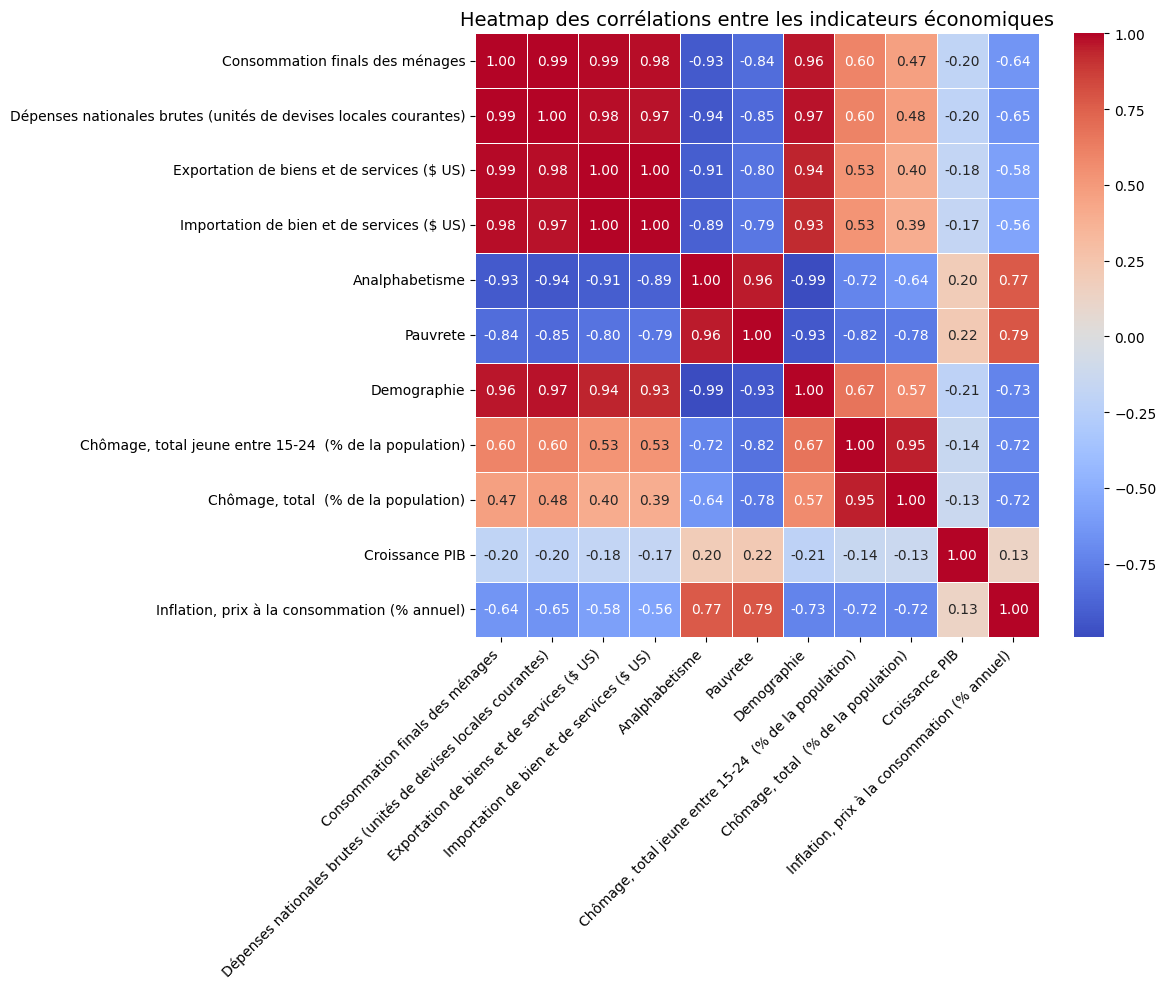

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



df = pd.read_excel("dataset timeseries.xlsx")

# Nettoyage des colonnes (enlever % et autres caractères non numériques)
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].replace(r"[^\d\.\-eE]", "", regex=True)
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Calculer la matrice de corrélation (hors colonne "Date" si présente)
df_corr = df.drop(columns=["Date"], errors="ignore").corr()


plt.figure(figsize=(12, 10))
sns.heatmap(df_corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Heatmap des corrélations entre les indicateurs économiques", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Aperçu des données brutes:
     Date Consommation finals des ménages  \
0  1974.0                   5 230 324 637   
1  1975.0                   6 234 936 719   
2  1976.0                   6 512 099 621   
3  1977.0                   7 421 104 219   
4  1978.0                   8 930 798 712   

   Dépenses nationales brutes (unités de devises locales courantes)  \
0                                       3.375330e+10                  
1                                       4.037000e+10                  
2                                       5.032500e+10                  
3                                       5.992480e+10                  
4                                       6.270870e+10                  

  Exportation de biens et de services ($ US)  \
0                              2 115 101 331   
1                              2 019 155 151   
2                              1 717 031 972   
3                              1 866 967 362   
4                              2 16

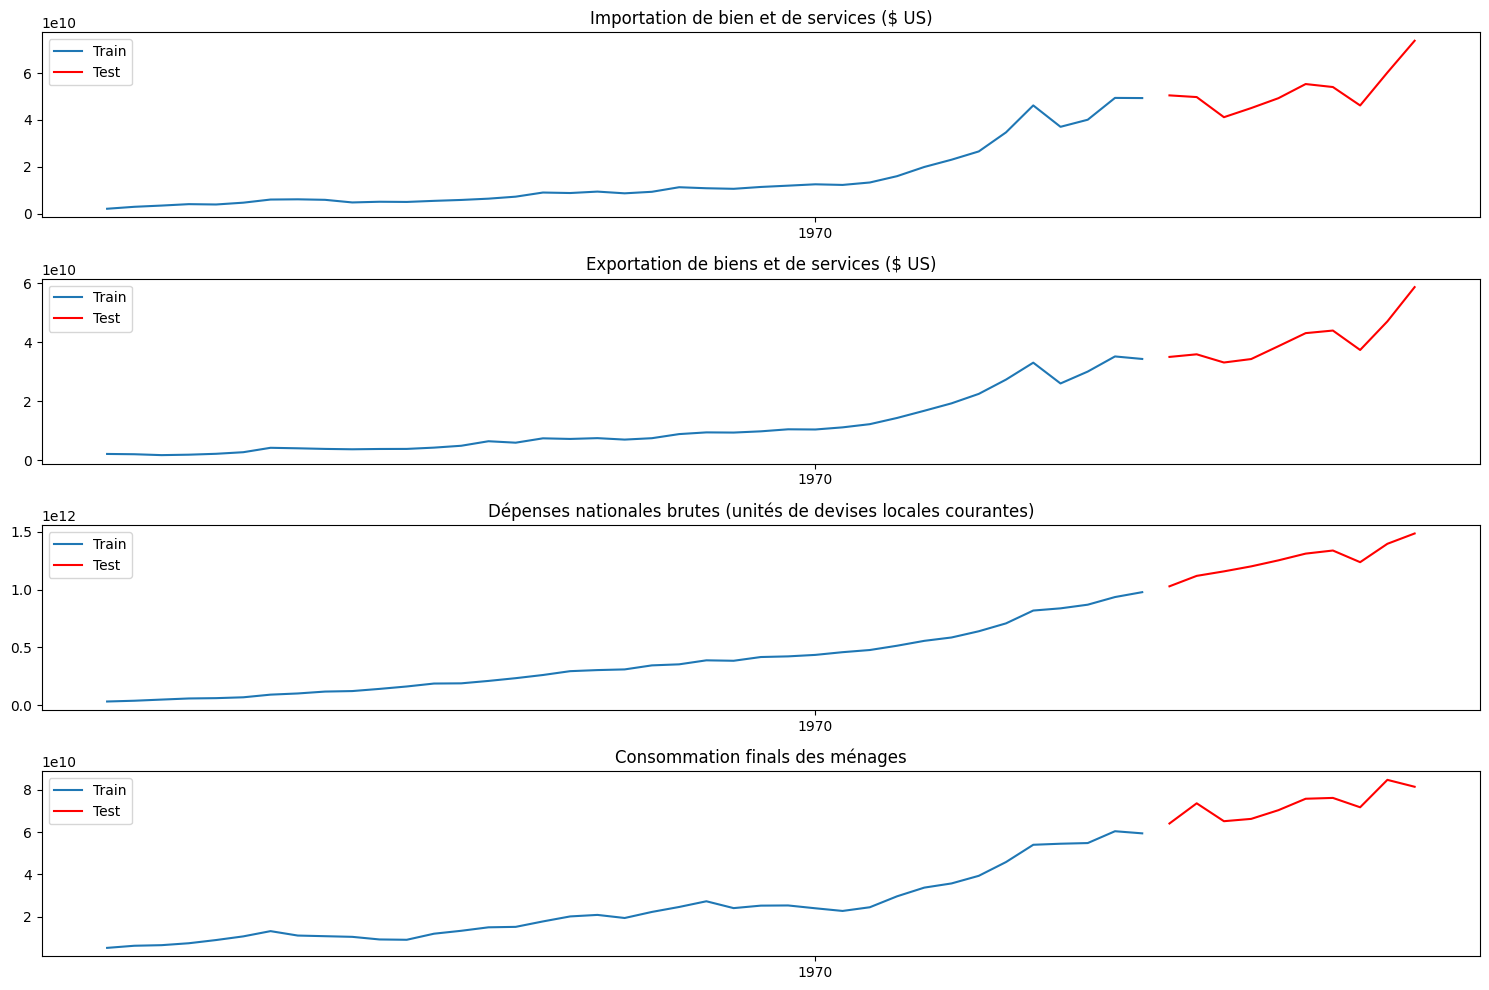


🔍 Test de stationnarité (avant différenciation) :
→ Importation de bien et de services ($ US): ADF p-value = 0.9988
→ Exportation de biens et de services ($ US): ADF p-value = 0.9991
→ Dépenses nationales brutes (unités de devises locales courantes): ADF p-value = 1.0000
→ Consommation finals des ménages: ADF p-value = 0.9982

🔁 Test de stationnarité (après différenciation) :
→ Importation de bien et de services ($ US): ADF p-value = 0.5394
→ Exportation de biens et de services ($ US): ADF p-value = 0.0000
→ Dépenses nationales brutes (unités de devises locales courantes): ADF p-value = 0.0018
→ Consommation finals des ménages: ADF p-value = 0.0003

✅ Lag optimal (AIC) : 5

Résumé du modèle VAR:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 22, Apr, 2025
Time:                     08:42:09
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:         

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)


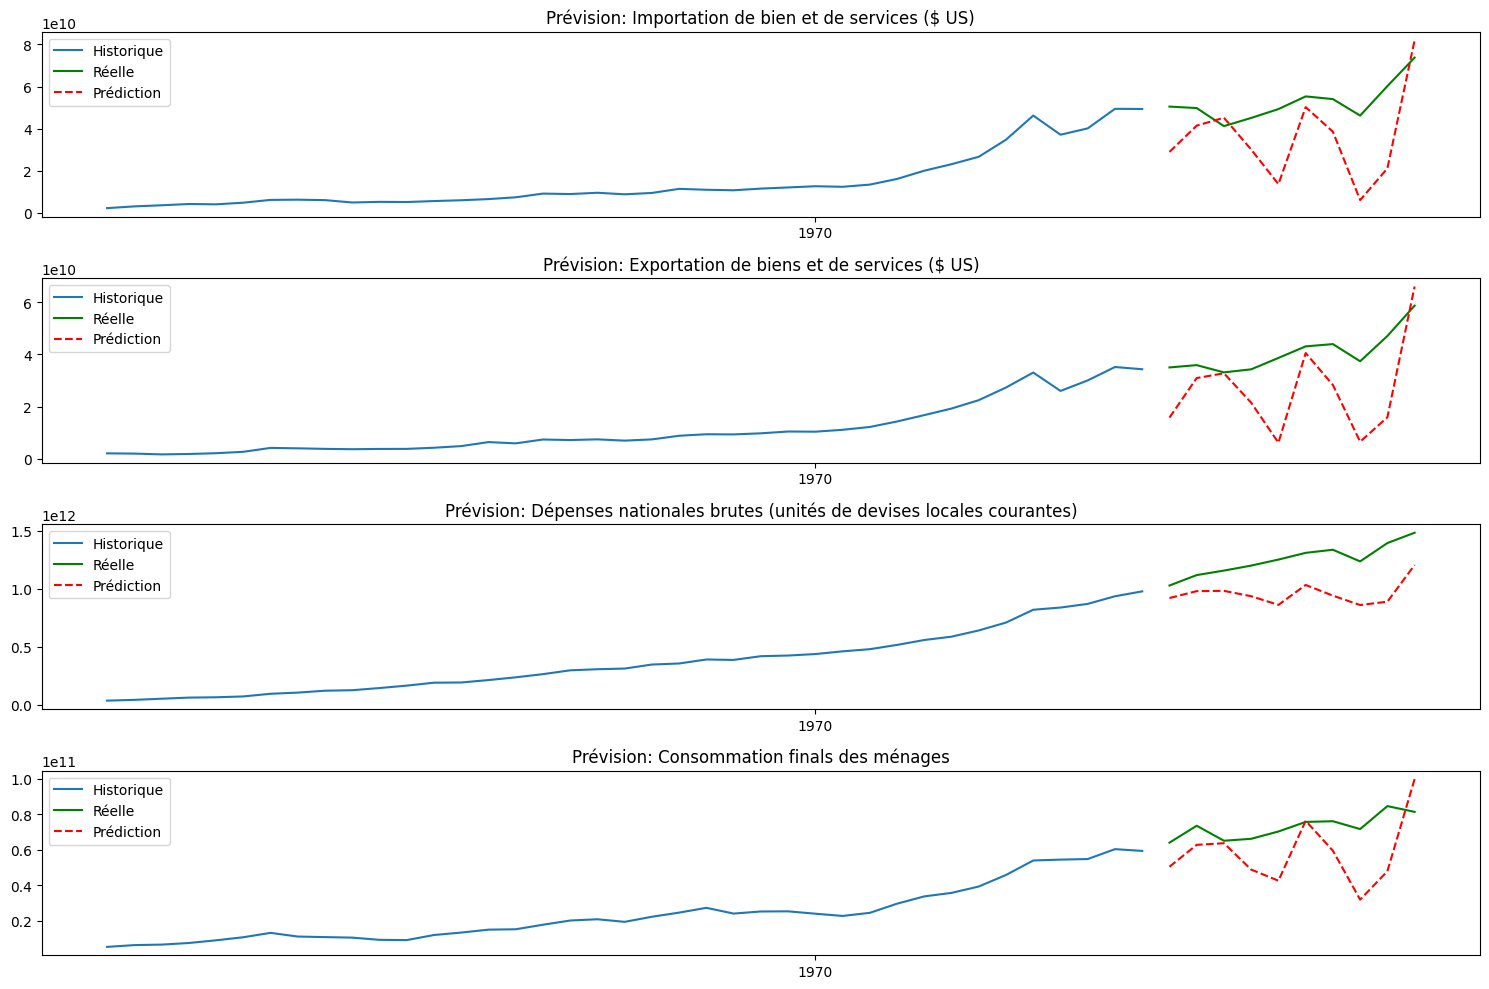


📈 Performances du modèle :
Importation de bien et de services ($ US):
  RMSE = 23521459824.85
  MAE = 19283321815.76
  MAPE = 37.62%
Exportation de biens et de services ($ US):
  RMSE = 19579846031.61
  MAE = 15722894649.37
  MAPE = 39.36%
Dépenses nationales brutes (unités de devises locales courantes):
  RMSE = 315326270530.96
  MAE = 291248572183.26
  MAPE = 22.77%
Consommation finals des ménages:
  RMSE = 22200826720.58
  MAE = 18322903615.41
  MAPE = 24.81%

Récapitulatif des performances:
                                            Variable          RMSE  \
0          Importation de bien et de services ($ US)  2.352146e+10   
1         Exportation de biens et de services ($ US)  1.957985e+10   
2  Dépenses nationales brutes (unités de devises ...  3.153263e+11   
3                    Consommation finals des ménages  2.220083e+10   

            MAE   MAPE (%)  
0  1.928332e+10  37.618467  
1  1.572289e+10  39.357584  
2  2.912486e+11  22.770533  
3  1.832290e+10  24.810837  

Ré

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fichiers disponibles pour téléchargement


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ÉTAPE 1: CHARGEMENT ET EXPLORATION DES DONNÉES
# Lire le fichier Excel
df = pd.read_excel("dataset timeseries.xlsx")
print("Aperçu des données brutes:")
print(df.head())
print("\nInformations sur le DataFrame:")
print(df.info())

# ÉTAPE 2: NETTOYAGE DES DONNÉES
# Nettoyer les colonnes numériques en supprimant les caractères non numériques
for col in df.columns:
    if col != "Date" and df[col].dtype == "object":
        df[col] = df[col].replace(r"[^\d\.\-eE]", "", regex=True)
        df[col] = pd.to_numeric(df[col], errors='coerce')

# ÉTAPE 3: TRAITEMENT DE LA DATE
# Afficher les premières dates pour diagnostiquer le format
print("\nDiagnostic des dates:")
print(df["Date"].head())

# Essayer différentes approches pour convertir la date correctement
try:
    # Si les dates sont des années simples (ex: 1970, 1971...)
    if df["Date"].dtype == 'int64' or (df["Date"].dtype == 'object' and df["Date"].str.len().max() <= 4):
        print("Dates détectées comme des années simples, conversion...")
        df["Date"] = pd.to_datetime(df["Date"], format='%Y')
    else:
        # Sinon, laisser pandas détecter le format
        df["Date"] = pd.to_datetime(df["Date"])
except Exception as e:
    print(f"Erreur lors de la conversion des dates: {e}")
    # Solution de secours: créer un index temporel artificiel
    print("Création d'un index temporel artificiel...")
    df["Date"] = pd.date_range(start='1970-01-01', periods=len(df), freq='Y')

# Définir la date comme index
df.set_index("Date", inplace=True)
print("\nAperçu après indexation par date:")
print(df.head())

# ÉTAPE 4: SÉLECTION DES VARIABLES
# Définir les colonnes du groupe 1
groupe1_cols = ["Importation de bien et de services ($ US)", "Exportation de biens et de services ($ US)",
               "Dépenses nationales brutes (unités de devises locales courantes)", "Consommation finals des ménages"]

# Vérifier l'existence des colonnes et ajuster si nécessaire
colonnes_disponibles = [col for col in groupe1_cols if col in df.columns]
if len(colonnes_disponibles) < len(groupe1_cols):
    print(f"\nAttention: Certaines colonnes ne sont pas disponibles. Utilisation de {len(colonnes_disponibles)} colonnes.")
    print(f"Colonnes utilisées: {colonnes_disponibles}")
    # Rechercher des colonnes similaires
    for col in groupe1_cols:
        if col not in df.columns:
            similar = [c for c in df.columns if any(word in c.lower() for word in col.lower().split())]
            if similar:
                print(f"Pour '{col}', colonnes similaires trouvées: {similar}")

# Sélectionner les colonnes et supprimer les NA
data = df[colonnes_disponibles].dropna()
print(f"\nDonnées après nettoyage: {data.shape[0]} lignes, {data.shape[1]} colonnes")

# ÉTAPE 5: DIVISION TRAIN/TEST
# Utiliser un partitionnement par position plutôt que par date
train_size = int(len(data) * 0.8)  # 80% pour l'entraînement
train = data.iloc[:train_size]
test = data.iloc[train_size:]

print(f"\nEnsemble d'entraînement: {train.shape[0]} lignes (de {train.index.min()} à {train.index.max()})")
print(f"Ensemble de test: {test.shape[0]} lignes (de {test.index.min()} à {test.index.max()})")

# Vérifier que nous avons suffisamment de données
if train.shape[0] < 2 or test.shape[0] < 1:
    raise ValueError("Pas assez de données pour l'analyse. Vérifiez votre fichier source.")

# ÉTAPE 6: VISUALISATION DES SÉRIES TEMPORELLES
plt.figure(figsize=(15, 10))
for i, col in enumerate(train.columns, 1):
    plt.subplot(len(train.columns), 1, i)
    plt.plot(train.index, train[col], label='Train')
    plt.plot(test.index, test[col], label='Test', color='red')
    plt.title(col)
    plt.legend()
plt.tight_layout()
plt.show()

# ÉTAPE 7: TEST DE STATIONNARITÉ
def adf_test(series, name):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f'→ {name}: ADF p-value = {result[1]:.4f}')
    return result[1] < 0.05  # Retourne True si la série est stationnaire (p < 0.05)

print("\n🔍 Test de stationnarité (avant différenciation) :")
stationary_before = {}
for col in train.columns:
    stationary_before[col] = adf_test(train[col], col)

# ÉTAPE 8: DIFFÉRENCIATION POUR STATIONNARITÉ
# Appliquer différenciation seulement aux séries non-stationnaires
train_diff = train.copy()
for col in train.columns:
    if not stationary_before[col]:
        train_diff[col] = train_diff[col].diff()
train_diff = train_diff.dropna()

# Re-test de stationnarité
print("\n🔁 Test de stationnarité (après différenciation) :")
for col in train_diff.columns:
    adf_test(train_diff[col], col)

# ÉTAPE 9: MODÉLISATION VAR
# Sélection du lag optimal
max_lags = min(5, int(train_diff.shape[0]/4))  # Limiter les lags à 1/4 de la taille de l'ensemble
model = VAR(train_diff)
lag_order = model.select_order(maxlags=max_lags).aic
print(f"\n✅ Lag optimal (AIC) : {lag_order}")

# Ajustement du modèle
model_fitted = model.fit(lag_order)
print("\nRésumé du modèle VAR:")
print(model_fitted.summary())

# ÉTAPE 10: PRÉVISION
# Prédiction pour la période de test
forecast_steps = len(test)
print(f"\nPrévision de {forecast_steps} étapes")

if train_diff.shape[0] <= lag_order:
    print(f"Attention: Pas assez de données ({train_diff.shape[0]}) pour le lag choisi ({lag_order}).")
    lag_order = min(1, train_diff.shape[0]-1)
    print(f"Ajustement du lag à {lag_order}")
    model_fitted = model.fit(lag_order)

# Générer les prévisions
forecast = model_fitted.forecast(train_diff.values[-lag_order:], steps=forecast_steps)
forecast_df = pd.DataFrame(forecast, index=test.index, columns=train_diff.columns)

# ÉTAPE 11: RECONSTRUCTION DES VALEURS NON-DIFFÉRENCIÉES
# Pour les séries qui ont été différenciées, reconstruire les valeurs initiales
forecast_levels = pd.DataFrame(index=test.index, columns=train.columns)
for col in train.columns:
    if not stationary_before[col]:
        # Pour les séries différenciées
        last_value = train[col].iloc[-1]
        forecast_levels[col] = last_value + forecast_df[col].cumsum()
    else:
        # Pour les séries déjà stationnaires
        forecast_levels[col] = forecast_df[col]

# ÉTAPE 12: VISUALISATION DES PRÉVISIONS
plt.figure(figsize=(15, 10))
for i, col in enumerate(train.columns, 1):
    plt.subplot(len(train.columns), 1, i)
    plt.plot(train.index, train[col], label='Historique')
    plt.plot(test.index, test[col], label='Réelle', color='green')
    plt.plot(test.index, forecast_levels[col], '--', label='Prédiction', color='red')
    plt.title(f'Prévision: {col}')
    plt.legend()
plt.tight_layout()
plt.savefig('VAR_predictions.png')  # Sauvegarder le graphique
plt.show()

# ÉTAPE 13: ÉVALUATION DES PERFORMANCES
print("\n📈 Performances du modèle :")
results = []
for col in train.columns:
    # Éviter les divisions par zéro dans le calcul du MAPE
    actual = test[col].values
    pred = forecast_levels[col].values

    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)

    # Calculer MAPE en évitant les divisions par zéro
    mape = np.mean(np.abs((actual - pred) / np.maximum(np.abs(actual), 1e-10))) * 100

    results.append([col, rmse, mae, mape])
    print(f"{col}:")
    print(f"  RMSE = {rmse:.2f}")
    print(f"  MAE = {mae:.2f}")
    print(f"  MAPE = {mape:.2f}%")

# Créer un tableau récapitulatif
results_df = pd.DataFrame(results, columns=['Variable', 'RMSE', 'MAE', 'MAPE (%)'])
print("\nRécapitulatif des performances:")
print(results_df)

# ÉTAPE 14: EXPORTATION DES RÉSULTATS
# Sauvegarder les prévisions dans un fichier CSV
results_df.to_csv('VAR_performance.csv')
forecast_export = pd.DataFrame({
    'Date': test.index,
})
for col in train.columns:
    forecast_export[f"{col} (Réelle)"] = test[col].values
    forecast_export[f"{col} (Prédiction)"] = forecast_levels[col].values

forecast_export.to_csv('VAR_forecasts.csv', index=False)
print("\nRésultats exportés dans 'VAR_performance.csv' et 'VAR_forecasts.csv'")

# Si Google Colab est utilisé, télécharger les fichiers
try:
    from google.colab import files
    files.download('VAR_predictions.png')
    files.download('VAR_performance.csv')
    files.download('VAR_forecasts.csv')
    print("Fichiers disponibles pour téléchargement")
except:
    print("Exécution en dehors de Google Colab. Les fichiers sont sauvegardés localement.")

CHARGEMENT ET PRÉPARATION DES DONNÉES
Aperçu des données brutes:
     Date Consommation finals des ménages  \
0  1974.0                   5 230 324 637   
1  1975.0                   6 234 936 719   
2  1976.0                   6 512 099 621   
3  1977.0                   7 421 104 219   
4  1978.0                   8 930 798 712   

   Dépenses nationales brutes (unités de devises locales courantes)  \
0                                       3.375330e+10                  
1                                       4.037000e+10                  
2                                       5.032500e+10                  
3                                       5.992480e+10                  
4                                       6.270870e+10                  

  Exportation de biens et de services ($ US)  \
0                              2 115 101 331   
1                              2 019 155 151   
2                              1 717 031 972   
3                              1 866 967 362 

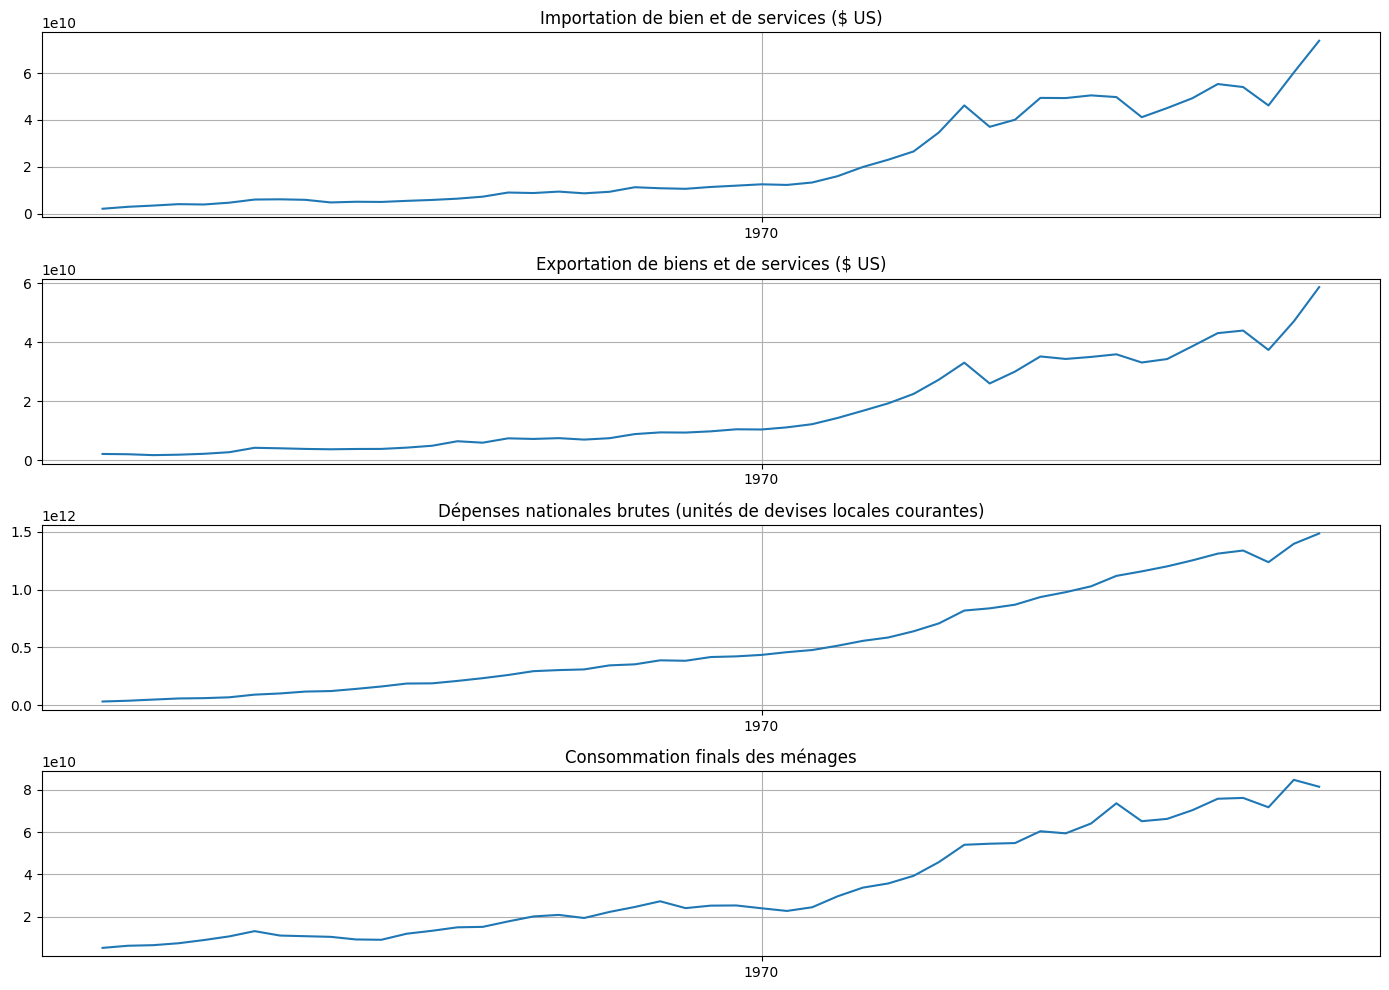


Ensemble d'entraînement: 39 lignes (de 1970-01-01 00:00:00.000001974 à 1970-01-01 00:00:00.000002012)
Ensemble de test: 10 lignes (de 1970-01-01 00:00:00.000002013 à 1970-01-01 00:00:00.000002022)

 NORMALISATION DES DONNÉES
Nombre de pas de temps pour les séquences: 3
Forme de X_train: (36, 3, 4), Forme de y_train: (36, 4)

 ENTRAÎNEMENT DU MODÈLE LSTM


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 3, 50)          │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 40)             │        14,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           164 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,724 (100.48 KB)

 Trainable params: 25,724 (100.48 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 546ms/step - loss: 0.0538 - val_loss: 0.6379
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0512 - val_loss: 0.6222
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.0486 - val_loss: 0.6055
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0465 - val_loss: 0.5882
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0438 - val_loss: 0.5702
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0413 - val_loss: 0.5509
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 0.0386 - val_loss: 0.5294
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - loss: 0.0361 - val_loss: 0.5061
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.0323 - val_loss: 0.4809
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0295 - val_loss: 0.4537
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.0283 - val_loss: 0.4246
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 3, 50)          │         2,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 40)             │         3,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           164 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,554 (25.60 KB)

 Trainable params: 6,554 (25.60 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 460ms/step - loss: 0.0992 - val_loss: 0.8815
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0703 - val_loss: 0.7796
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0660 - val_loss: 0.6947
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0584 - val_loss: 0.6210
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0520 - val_loss: 0.5563
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0472 - val_loss: 0.5015
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0444 - val_loss: 0.4563
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0370 - val_loss: 0.4202
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0336 - val_loss: 0.3833
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0280 - val_loss: 0.3380
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0248 - val_loss: 0.2915
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0211 - 

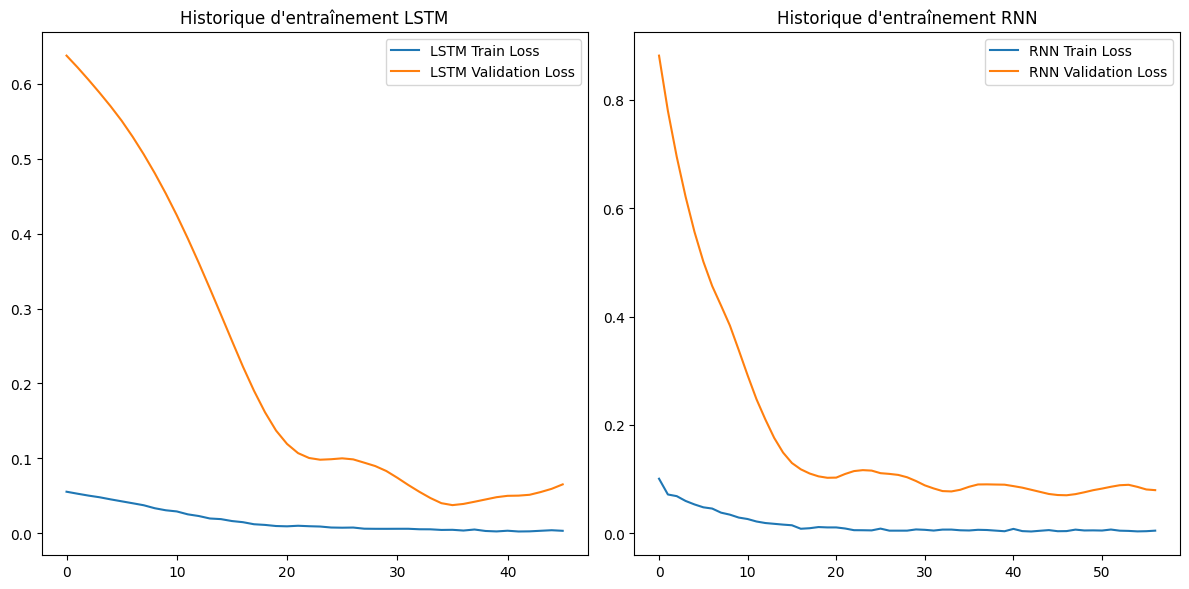


Forme de X_test: (7, 3, 4), Forme de y_test: (7, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


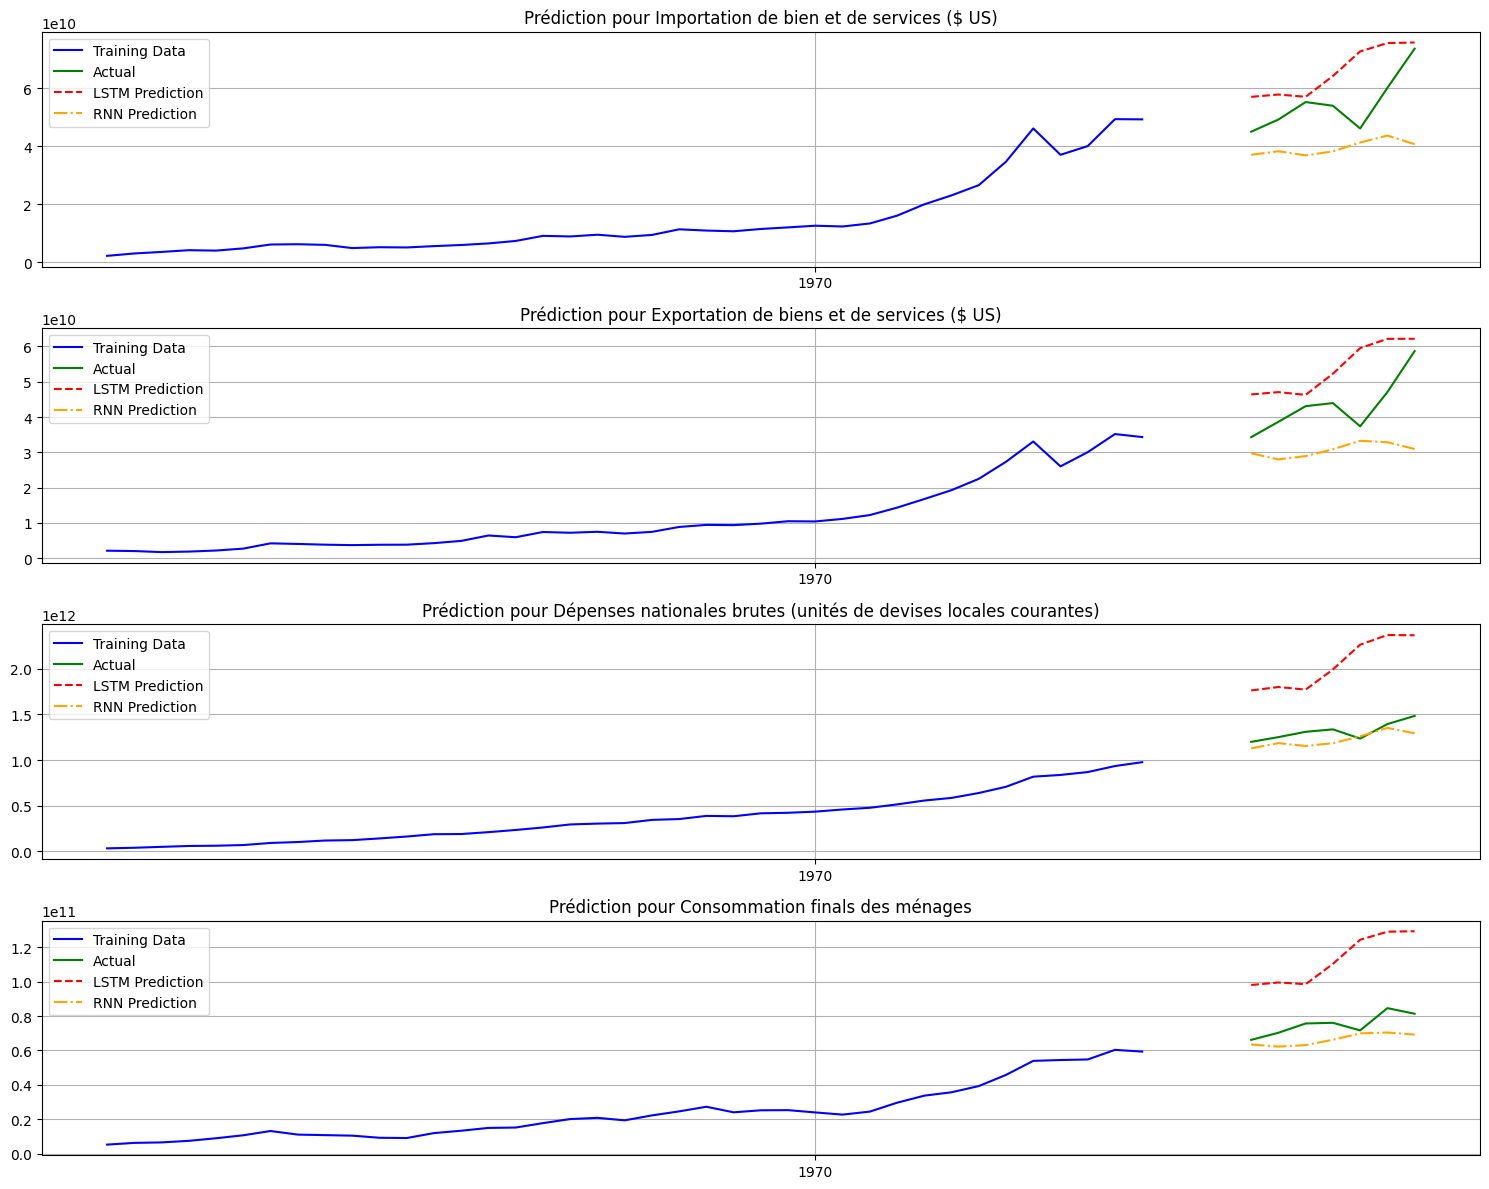


 PERFORMANCES DES MODÈLES:

Importation de bien et de services ($ US):
  LSTM: RMSE = 13531582623.66, MAE = 11001202283.14, MAPE = 21.83%
  RNN:  RMSE = 17547354050.30, MAE = 15350056194.57, MAPE = 26.44%

Exportation de biens et de services ($ US):
  LSTM: RMSE = 12119684337.80, MAE = 10400899705.43, MAPE = 25.83%
  RNN:  RMSE = 14612819484.59, MAE = 12644998534.57, MAPE = 27.42%

Dépenses nationales brutes (unités de devises locales courantes):
  LSTM: RMSE = 760504153368.93, MAE = 730790332480.00, MAPE = 55.38%
  RNN:  RMSE = 116413915660.39, MAE = 99922299401.14, MAPE = 7.44%

Consommation finals des ménages:
  LSTM: RMSE = 38977017982.77, MAE = 37644615051.00, MAPE = 50.02%
  RNN:  RMSE = 9854369455.36, MAE = 8754851298.71, MAPE = 11.32%

RÉCAPITULATIF DES PERFORMANCES:
                                            Variable     LSTM_RMSE  \
0          Importation de bien et de services ($ US)  1.353158e+10   
1         Exportation de biens et de services ($ US)  1.211968e+10   
2  

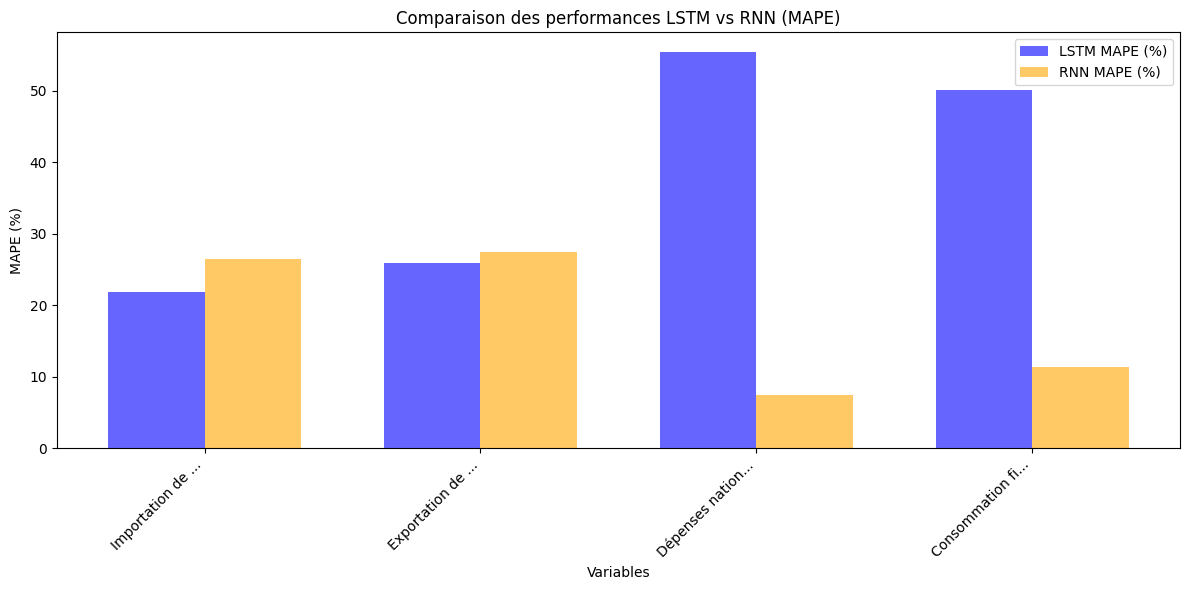


Résultats exportés dans 'lstm_rnn_predictions.csv' et 'lstm_rnn_performance.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fichiers disponibles pour téléchargement

 ANALYSE COMPLÉTÉE!


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# ÉTAPE 1: CHARGEMENT ET EXPLORATION DES DONNÉES
print("CHARGEMENT ET PRÉPARATION DES DONNÉES")
# Lire le fichier Excel
df = pd.read_excel("dataset timeseries.xlsx")
print("Aperçu des données brutes:")
print(df.head())

# ÉTAPE 2: NETTOYAGE DES DONNÉES
# Nettoyer les colonnes numériques en supprimant les caractères non numériques
for col in df.columns:
    if col != "Date" and df[col].dtype == "object":
        df[col] = df[col].replace(r"[^\d\.\-eE]", "", regex=True)
        df[col] = pd.to_numeric(df[col], errors='coerce')

# ÉTAPE 3: TRAITEMENT DE LA DATE
# Essayer différentes approches pour convertir la date correctement
try:
    # Si les dates sont des années simples (ex: 1970, 1971...)
    if df["Date"].dtype == 'int64' or (df["Date"].dtype == 'object' and df["Date"].str.len().max() <= 4):
        print("Dates détectées comme des années simples, conversion...")
        df["Date"] = pd.to_datetime(df["Date"], format='%Y')
    else:
        # Sinon, laisser pandas détecter le format
        df["Date"] = pd.to_datetime(df["Date"])
except Exception as e:
    print(f"Erreur lors de la conversion des dates: {e}")
    # Solution de secours: créer un index temporel artificiel
    print("Création d'un index temporel artificiel...")
    df["Date"] = pd.date_range(start='1970-01-01', periods=len(df), freq='Y')

# Définir la date comme index
df.set_index("Date", inplace=True)

# ÉTAPE 4: SÉLECTION DES VARIABLES
# Définir les colonnes du groupe 1
groupe1_cols = ["Importation de bien et de services ($ US)", "Exportation de biens et de services ($ US)",
               "Dépenses nationales brutes (unités de devises locales courantes)", "Consommation finals des ménages"]

# Vérifier l'existence des colonnes et ajuster si nécessaire
colonnes_disponibles = [col for col in groupe1_cols if col in df.columns]
if len(colonnes_disponibles) < len(groupe1_cols):
    print(f"\nAttention: Certaines colonnes ne sont pas disponibles. Utilisation de {len(colonnes_disponibles)} colonnes.")
    print(f"Colonnes utilisées: {colonnes_disponibles}")

# Sélectionner les colonnes et supprimer les NA
data = df[colonnes_disponibles].dropna()
print(f"\nDonnées après nettoyage: {data.shape[0]} lignes, {data.shape[1]} colonnes")

# ÉTAPE 5: VISUALISATION DES SÉRIES TEMPORELLES
plt.figure(figsize=(14, 10))
for i, column in enumerate(data.columns, 1):
    plt.subplot(len(data.columns), 1, i)
    plt.plot(data.index, data[column])
    plt.title(column)
    plt.grid(True)
plt.tight_layout()
plt.savefig('time_series_data.png')
plt.show()

# ÉTAPE 6: DIVISION TRAIN/TEST
# Utiliser un partitionnement par position
train_size = int(len(data) * 0.8)
train = data.iloc[:train_size]
test = data.iloc[train_size:]

print(f"\nEnsemble d'entraînement: {train.shape[0]} lignes (de {train.index.min()} à {train.index.max()})")
print(f"Ensemble de test: {test.shape[0]} lignes (de {test.index.min()} à {test.index.max()})")

# ÉTAPE 7: NORMALISATION DES DONNÉES
print("\n NORMALISATION DES DONNÉES")
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# ÉTAPE 8: PRÉPARATION DES DONNÉES POUR LES MODÈLES SÉQUENTIELS
def create_sequences(data, time_steps):
    """Création de séquences pour l'entraînement des modèles RNN/LSTM"""
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), :])
        y.append(data[i + time_steps, :])
    return np.array(X), np.array(y)

# Paramètres pour la création des séquences
time_steps = min(3, train_scaled.shape[0] // 3)  # Utiliser un nombre de pas de temps adapté à la taille des données
print(f"Nombre de pas de temps pour les séquences: {time_steps}")

# Créer des séquences pour l'entraînement
X_train, y_train = create_sequences(train_scaled, time_steps)
print(f"Forme de X_train: {X_train.shape}, Forme de y_train: {y_train.shape}")

# ÉTAPE 9: CRÉATION ET ENTRAÎNEMENT DU MODÈLE LSTM
print("\n ENTRAÎNEMENT DU MODÈLE LSTM")
# Configuration de TensorFlow pour des résultats reproductibles
tf.random.set_seed(42)
np.random.seed(42)

# Modèle LSTM
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(40, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(y_train.shape[1])
])

lstm_model.compile(optimizer='adam', loss='mse')
print(lstm_model.summary())

# Callbacks pour l'arrêt précoce
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entraînement du modèle LSTM avec validation
lstm_history = lstm_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# ÉTAPE 10: CRÉATION ET ENTRAÎNEMENT DU MODÈLE RNN SIMPLE
print("\n ENTRAÎNEMENT DU MODÈLE RNN")
# Modèle RNN
rnn_model = Sequential([
    SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    SimpleRNN(40, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(y_train.shape[1])
])

rnn_model.compile(optimizer='adam', loss='mse')
print(rnn_model.summary())

# Entraînement du modèle RNN
rnn_history = rnn_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# ÉTAPE 11: VISUALISATION DE L'HISTORIQUE D'ENTRAÎNEMENT
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['loss'], label='LSTM Train Loss')
plt.plot(lstm_history.history['val_loss'], label='LSTM Validation Loss')
plt.title('Historique d\'entraînement LSTM')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rnn_history.history['loss'], label='RNN Train Loss')
plt.plot(rnn_history.history['val_loss'], label='RNN Validation Loss')
plt.title('Historique d\'entraînement RNN')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# ÉTAPE 12: PRÉPARATION DES DONNÉES DE TEST POUR LA PRÉDICTION
X_test, y_test = create_sequences(test_scaled, time_steps)
print(f"\nForme de X_test: {X_test.shape}, Forme de y_test: {y_test.shape}")

# Si le test set est trop petit pour créer des séquences, utiliser une approche différente
if X_test.shape[0] == 0:
    print("Ensemble de test trop petit pour créer des séquences. Utilisation des dernières données d'entraînement.")
    X_test = X_train[-1:].copy()  # Utiliser la dernière séquence d'entraînement

    # Pour la prédiction itérative
    pred_sequence = train_scaled[-time_steps:].copy()
    lstm_preds = []
    rnn_preds = []

    # Générer des prédictions pas à pas
    for _ in range(len(test)):
        # Préparer l'entrée pour les modèles
        x_input = pred_sequence.reshape(1, time_steps, train.shape[1])

        # Prédire avec LSTM et RNN
        lstm_pred = lstm_model.predict(x_input, verbose=0)
        rnn_pred = rnn_model.predict(x_input, verbose=0)

        # Ajouter les prédictions
        lstm_preds.append(lstm_pred[0])
        rnn_preds.append(rnn_pred[0])

        # Mettre à jour la séquence pour la prochaine prédiction
        pred_sequence = np.vstack([pred_sequence[1:], lstm_pred])

    # Convertir en arrays
    lstm_preds = np.array(lstm_preds)
    rnn_preds = np.array(rnn_preds)
else:
    # Prédiction avec les modèles
    lstm_preds = lstm_model.predict(X_test)
    rnn_preds = rnn_model.predict(X_test)

# ÉTAPE 13: INVERSION DE LA NORMALISATION
# Transformer les prédictions dans l'échelle d'origine
if X_test.shape[0] > 0:
    # Créer des arrays de test pour l'évaluation
    y_test_dates = test.index[time_steps:time_steps+len(y_test)]
    y_test_orig = scaler.inverse_transform(y_test)

    lstm_preds_orig = scaler.inverse_transform(lstm_preds)
    rnn_preds_orig = scaler.inverse_transform(rnn_preds)
else:
    # Si on a utilisé l'approche itérative
    y_test_dates = test.index
    y_test_orig = test.values

    lstm_preds_orig = scaler.inverse_transform(lstm_preds)
    rnn_preds_orig = scaler.inverse_transform(rnn_preds)

# ÉTAPE 14: VISUALISATION DES PRÉDICTIONS
plt.figure(figsize=(15, 12))
for i, col_idx in enumerate(range(data.shape[1])):
    plt.subplot(data.shape[1], 1, i+1)

    # Plot des données d'entraînement
    plt.plot(train.index, train.iloc[:, col_idx], label='Training Data', color='blue')

    # Plot des données de test réelles
    plt.plot(y_test_dates, y_test_orig[:, col_idx], label='Actual', color='green')

    # Plot des prédictions LSTM et RNN
    plt.plot(y_test_dates, lstm_preds_orig[:, col_idx], label='LSTM Prediction', color='red', linestyle='--')
    plt.plot(y_test_dates, rnn_preds_orig[:, col_idx], label='RNN Prediction', color='orange', linestyle='-.')

    plt.title(f'Prédiction pour {data.columns[col_idx]}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.savefig('lstm_rnn_predictions.png')
plt.show()

# ÉTAPE 15: ÉVALUATION DES PERFORMANCES
print("\n PERFORMANCES DES MODÈLES:")
results = []

for i, col in enumerate(data.columns):
    # RMSE et MAE pour LSTM
    lstm_rmse = np.sqrt(mean_squared_error(y_test_orig[:, i], lstm_preds_orig[:, i]))
    lstm_mae = mean_absolute_error(y_test_orig[:, i], lstm_preds_orig[:, i])

    # MAPE pour LSTM (avec protection contre division par zéro)
    lstm_mape = np.mean(np.abs((y_test_orig[:, i] - lstm_preds_orig[:, i]) / np.maximum(np.abs(y_test_orig[:, i]), 1e-10))) * 100

    # RMSE et MAE pour RNN
    rnn_rmse = np.sqrt(mean_squared_error(y_test_orig[:, i], rnn_preds_orig[:, i]))
    rnn_mae = mean_absolute_error(y_test_orig[:, i], rnn_preds_orig[:, i])

    # MAPE pour RNN
    rnn_mape = np.mean(np.abs((y_test_orig[:, i] - rnn_preds_orig[:, i]) / np.maximum(np.abs(y_test_orig[:, i]), 1e-10))) * 100

    # Ajouter aux résultats
    results.append([
        col,
        lstm_rmse, lstm_mae, lstm_mape,
        rnn_rmse, rnn_mae, rnn_mape
    ])

    print(f"\n{col}:")
    print(f"  LSTM: RMSE = {lstm_rmse:.2f}, MAE = {lstm_mae:.2f}, MAPE = {lstm_mape:.2f}%")
    print(f"  RNN:  RMSE = {rnn_rmse:.2f}, MAE = {rnn_mae:.2f}, MAPE = {rnn_mape:.2f}%")

# Créer un tableau récapitulatif
results_df = pd.DataFrame(
    results,
    columns=['Variable', 'LSTM_RMSE', 'LSTM_MAE', 'LSTM_MAPE (%)', 'RNN_RMSE', 'RNN_MAE', 'RNN_MAPE (%)']
)
print("\nRÉCAPITULATIF DES PERFORMANCES:")
print(results_df)

# ÉTAPE 16: COMPARAISON DES MODÈLES
plt.figure(figsize=(12, 6))
variables = results_df['Variable'].str[:15] + '...'  # Tronquer les noms longs
x = np.arange(len(variables))
width = 0.35

plt.bar(x - width/2, results_df['LSTM_MAPE (%)'], width, label='LSTM MAPE (%)', color='blue', alpha=0.6)
plt.bar(x + width/2, results_df['RNN_MAPE (%)'], width, label='RNN MAPE (%)', color='orange', alpha=0.6)

plt.xlabel('Variables')
plt.ylabel('MAPE (%)')
plt.title('Comparaison des performances LSTM vs RNN (MAPE)')
plt.xticks(x, variables, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()

# ÉTAPE 17: EXPORTATION DES RÉSULTATS
# Créer un DataFrame avec les prédictions
predictions_df = pd.DataFrame(index=y_test_dates)

for i, col in enumerate(data.columns):
    predictions_df[f"{col} (Réelle)"] = y_test_orig[:, i]
    predictions_df[f"{col} (LSTM)"] = lstm_preds_orig[:, i]
    predictions_df[f"{col} (RNN)"] = rnn_preds_orig[:, i]

# Sauvegarder les résultats
predictions_df.to_csv('lstm_rnn_predictions.csv')
results_df.to_csv('lstm_rnn_performance.csv')

print("\nRésultats exportés dans 'lstm_rnn_predictions.csv' et 'lstm_rnn_performance.csv'")

# Si Google Colab est utilisé, télécharger les fichiers
try:
    from google.colab import files
    files.download('time_series_data.png')
    files.download('training_history.png')
    files.download('lstm_rnn_predictions.png')
    files.download('model_comparison.png')
    files.download('lstm_rnn_predictions.csv')
    files.download('lstm_rnn_performance.csv')
    print("Fichiers disponibles pour téléchargement")
except:
    print("Exécution en dehors de Google Colab. Les fichiers sont sauvegardés localement.")

print("\n ANALYSE COMPLÉTÉE!")

CHARGEMENT ET PRÉPARATION DES DONNÉES
Aperçu des données brutes:
     Date Consommation finals des ménages  \
0  1974.0                   5 230 324 637   
1  1975.0                   6 234 936 719   
2  1976.0                   6 512 099 621   
3  1977.0                   7 421 104 219   
4  1978.0                   8 930 798 712   

   Dépenses nationales brutes (unités de devises locales courantes)  \
0                                       3.375330e+10                  
1                                       4.037000e+10                  
2                                       5.032500e+10                  
3                                       5.992480e+10                  
4                                       6.270870e+10                  

  Exportation de biens et de services ($ US)  \
0                              2 115 101 331   
1                              2 019 155 151   
2                              1 717 031 972   
3                              1 866 967 362 

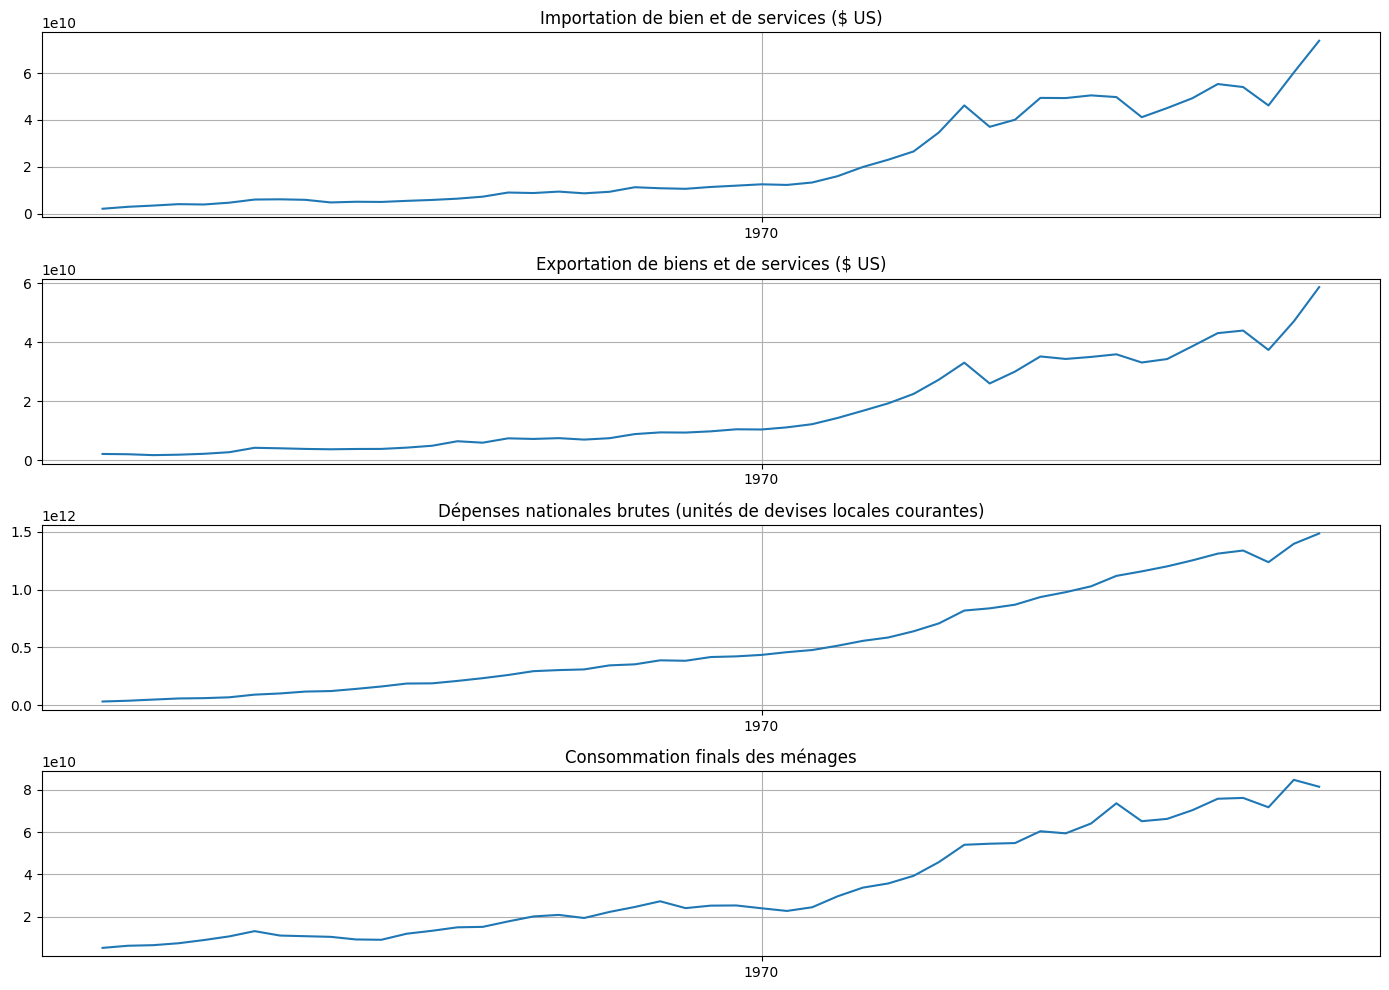


Ensemble d'entraînement: 39 lignes (de 1970-01-01 00:00:00.000001974 à 1970-01-01 00:00:00.000002012)
Ensemble de test: 10 lignes (de 1970-01-01 00:00:00.000002013 à 1970-01-01 00:00:00.000002022)

 NORMALISATION DES DONNÉES
Nombre de pas de temps pour les séquences: 3
Forme de X_train: (36, 3, 4), Forme de y_train: (36, 4)

 ENTRAÎNEMENT DU MODÈLE LSTM


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 3, 50)          │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 3, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 40)             │        14,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │           164 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,724 (100.48 KB)

 Trainable params: 25,724 (100.48 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 596ms/step - loss: 0.0564 - val_loss: 0.6697
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0536 - val_loss: 0.6539
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0511 - val_loss: 0.6386
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0486 - val_loss: 0.6237
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0466 - val_loss: 0.6086
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0444 - val_loss: 0.5925
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0434 - val_loss: 0.5756
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0404 - val_loss: 0.5577
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0376 - val_loss: 0.5385
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0354 - val_loss: 0.5180
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0331 - val_loss: 0.4957
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0300 - 

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)        │ (None, 3, 50)          │         2,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 3, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 40)             │         3,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           164 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,554 (25.60 KB)

 Trainable params: 6,554 (25.60 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 518ms/step - loss: 0.0922 - val_loss: 0.7596
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0575 - val_loss: 0.5610
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0408 - val_loss: 0.3947
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0346 - val_loss: 0.2649
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0162 - val_loss: 0.1683
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.0148 - val_loss: 0.1052
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0092 - val_loss: 0.0686
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0121 - val_loss: 0.0524
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0146 - val_loss: 0.0439
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0103 - val_loss: 0.0411
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0107 - val_loss: 0.0421
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0154 

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, 3, 50)          │         8,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 3, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 40)             │        11,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │           164 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,604 (76.58 KB)

 Trainable params: 19,604 (76.58 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 0.0589 - val_loss: 0.6865
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.0545 - val_loss: 0.6598
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.0510 - val_loss: 0.6364
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0469 - val_loss: 0.6149
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0430 - val_loss: 0.5950
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.0405 - val_loss: 0.5755
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0370 - val_loss: 0.5528
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0344 - val_loss: 0.5292
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0316 - val_loss: 0.5046
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0277 - val_loss: 0.4791
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0246 - val_loss: 0.4525
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0225

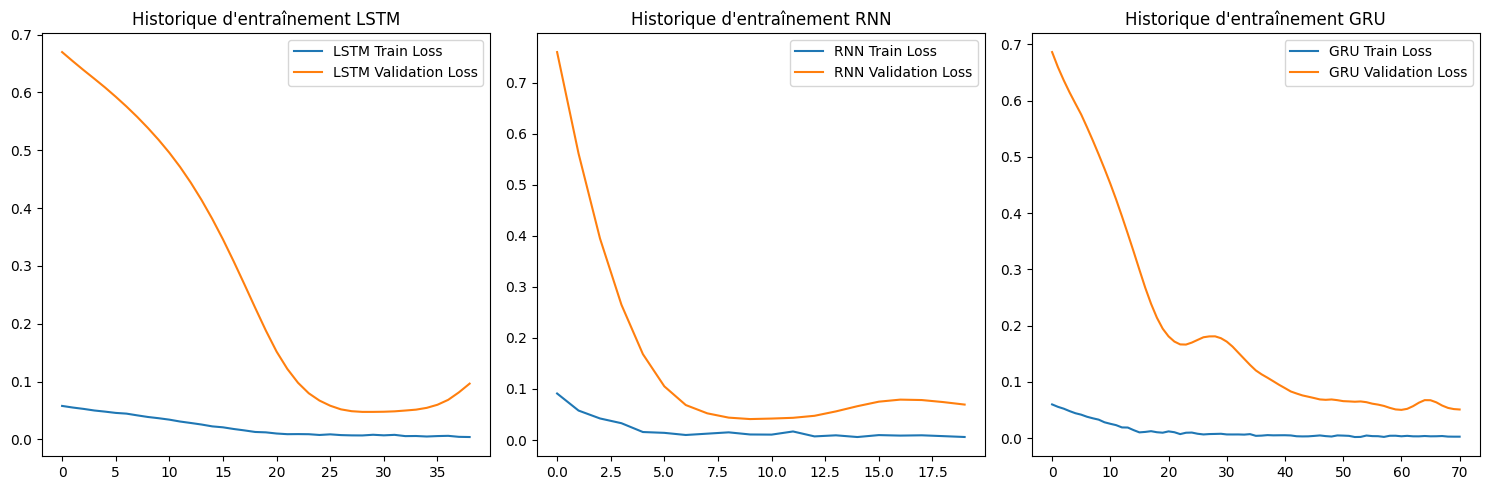


Forme de X_test: (7, 3, 4), Forme de y_test: (7, 4)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


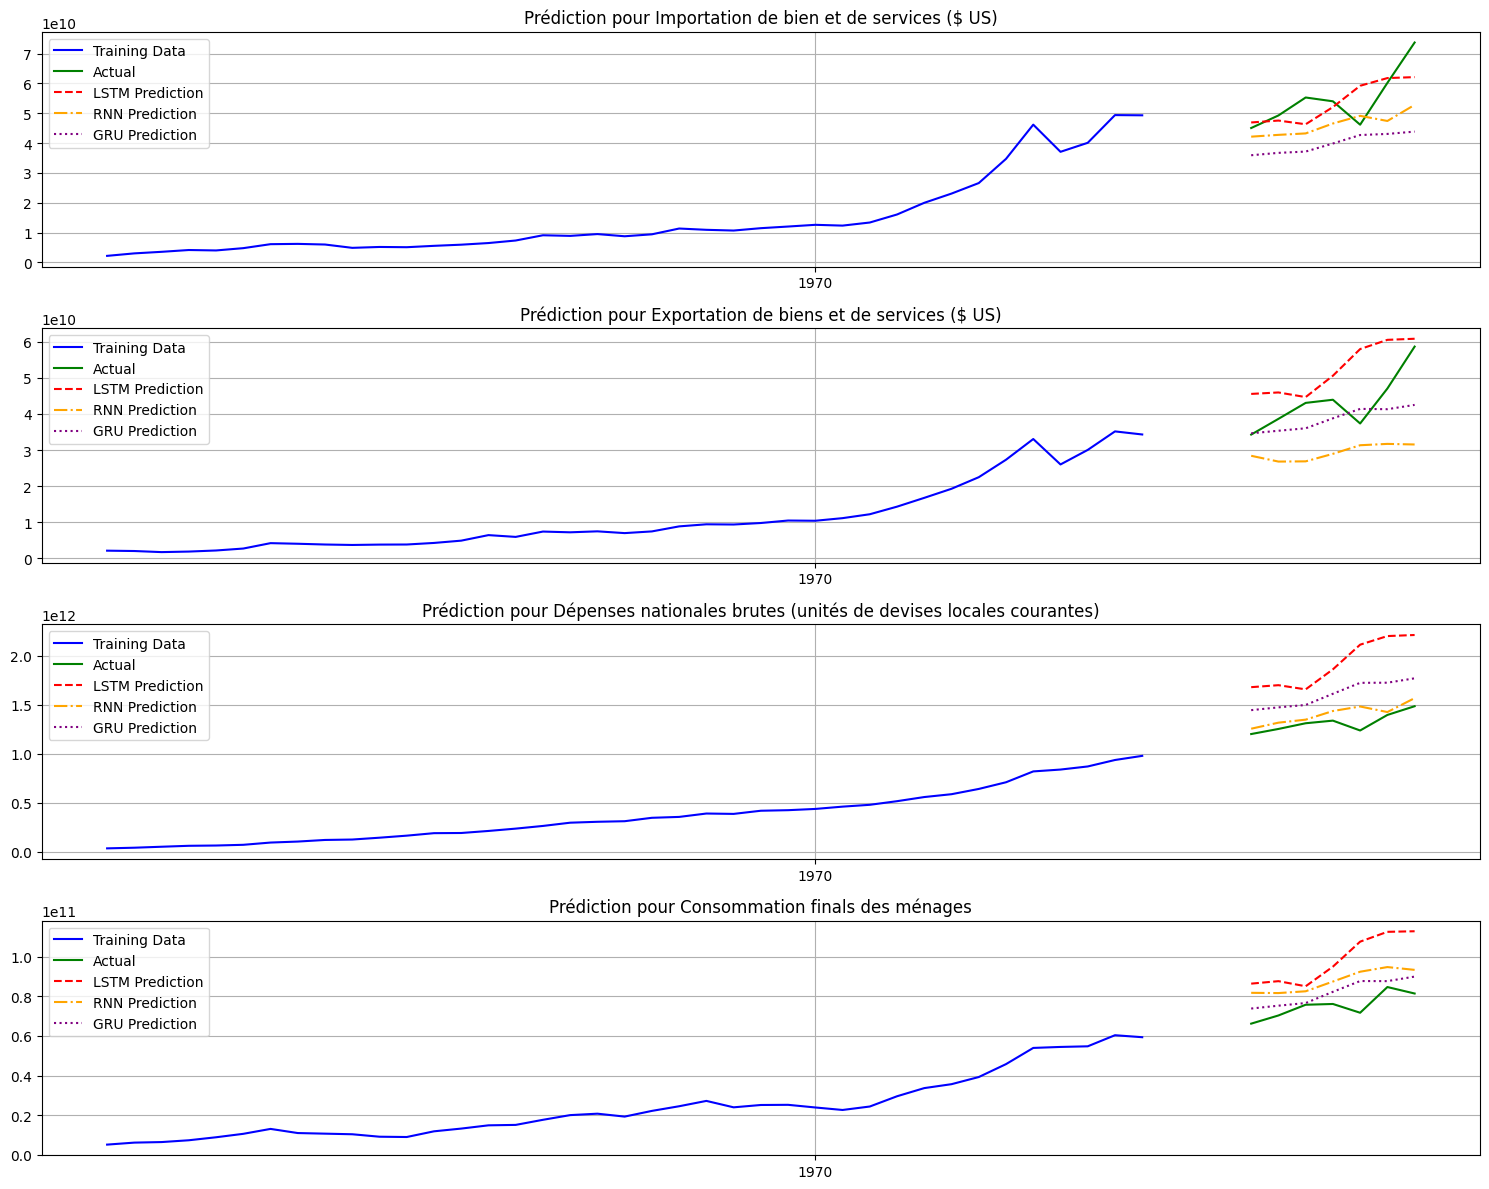


 PERFORMANCES DES MODÈLES:

Importation de bien et de services ($ US):
  LSTM: RMSE = 7549082560.21, MAE = 5826416232.86, MAPE = 10.59%
  RNN:  RMSE = 11094457854.03, MAE = 9370402876.00, MAPE = 15.90%
  GRU:  RMSE = 16775501628.87, MAE = 14926552030.00, MAPE = 25.90%

Exportation de biens et de services ($ US):
  LSTM: RMSE = 10954662734.89, MAE = 9023105950.00, MAPE = 22.61%
  RNN:  RMSE = 15446085991.34, MAE = 13917245391.71, MAPE = 30.64%
  GRU:  RMSE = 7534876996.09, MAE = 5968235937.71, MAPE = 12.60%

Dépenses nationales brutes (unités de devises locales courantes):
  LSTM: RMSE = 628239580413.08, MAE = 599998732937.14, MAPE = 45.50%
  RNN:  RMSE = 110623815834.85, MAE = 87167642834.29, MAPE = 6.75%
  GRU:  RMSE = 303145248038.15, MAE = 289160717229.71, MAPE = 22.11%

Consommation finals des ménages:
  LSTM: RMSE = 24465102371.14, MAE = 22947640422.43, MAPE = 30.50%
  RNN:  RMSE = 13165788159.67, MAE = 12509985016.71, MAPE = 16.96%
  GRU:  RMSE = 8084412686.89, MAE = 6715603192.

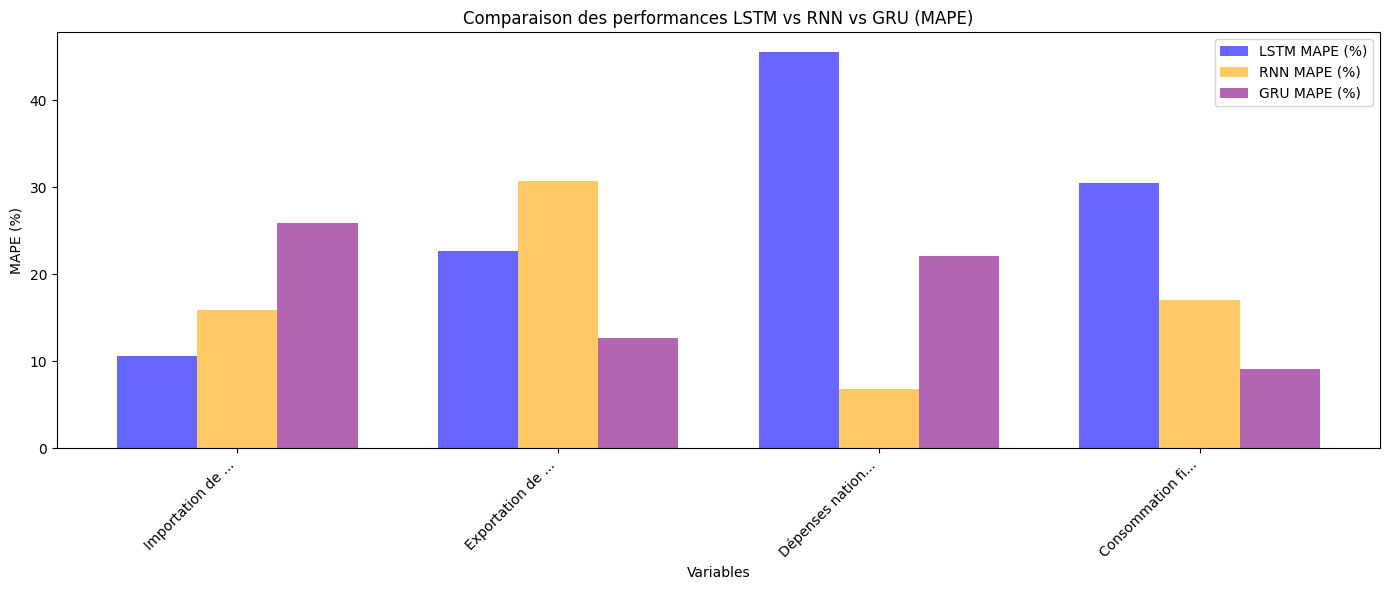


Résultats exportés dans 'lstm_rnn_gru_predictions.csv' et 'lstm_rnn_gru_performance.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fichiers disponibles pour téléchargement

 ANALYSE COMPLÉTÉE AVEC GRU!


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, GRU, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# ÉTAPE 1: CHARGEMENT ET EXPLORATION DES DONNÉES
print("CHARGEMENT ET PRÉPARATION DES DONNÉES")
# Lire le fichier Excel
df = pd.read_excel("dataset timeseries.xlsx")
print("Aperçu des données brutes:")
print(df.head())

# ÉTAPE 2: NETTOYAGE DES DONNÉES
# Nettoyer les colonnes numériques en supprimant les caractères non numériques
for col in df.columns:
    if col != "Date" and df[col].dtype == "object":
        df[col] = df[col].replace(r"[^\d\.\-eE]", "", regex=True)
        df[col] = pd.to_numeric(df[col], errors='coerce')

# ÉTAPE 3: TRAITEMENT DE LA DATE
# Essayer différentes approches pour convertir la date correctement
try:
    # Si les dates sont des années simples (ex: 1970, 1971...)
    if df["Date"].dtype == 'int64' or (df["Date"].dtype == 'object' and df["Date"].str.len().max() <= 4):
        print("Dates détectées comme des années simples, conversion...")
        df["Date"] = pd.to_datetime(df["Date"], format='%Y')
    else:
        # Sinon, laisser pandas détecter le format
        df["Date"] = pd.to_datetime(df["Date"])
except Exception as e:
    print(f"Erreur lors de la conversion des dates: {e}")
    # Solution de secours: créer un index temporel artificiel
    print("Création d'un index temporel artificiel...")
    df["Date"] = pd.date_range(start='1970-01-01', periods=len(df), freq='Y')

# Définir la date comme index
df.set_index("Date", inplace=True)

# ÉTAPE 4: SÉLECTION DES VARIABLES
# Définir les colonnes du groupe 1
groupe1_cols = ["Importation de bien et de services ($ US)", "Exportation de biens et de services ($ US)",
               "Dépenses nationales brutes (unités de devises locales courantes)", "Consommation finals des ménages"]

# Vérifier l'existence des colonnes et ajuster si nécessaire
colonnes_disponibles = [col for col in groupe1_cols if col in df.columns]
if len(colonnes_disponibles) < len(groupe1_cols):
    print(f"\nAttention: Certaines colonnes ne sont pas disponibles. Utilisation de {len(colonnes_disponibles)} colonnes.")
    print(f"Colonnes utilisées: {colonnes_disponibles}")

# Sélectionner les colonnes et supprimer les NA
data = df[colonnes_disponibles].dropna()
print(f"\nDonnées après nettoyage: {data.shape[0]} lignes, {data.shape[1]} colonnes")

# ÉTAPE 5: VISUALISATION DES SÉRIES TEMPORELLES
plt.figure(figsize=(14, 10))
for i, column in enumerate(data.columns, 1):
    plt.subplot(len(data.columns), 1, i)
    plt.plot(data.index, data[column])
    plt.title(column)
    plt.grid(True)
plt.tight_layout()
plt.savefig('time_series_data.png')
plt.show()

# ÉTAPE 6: DIVISION TRAIN/TEST
# Utiliser un partitionnement par position
train_size = int(len(data) * 0.8)
train = data.iloc[:train_size]
test = data.iloc[train_size:]

print(f"\nEnsemble d'entraînement: {train.shape[0]} lignes (de {train.index.min()} à {train.index.max()})")
print(f"Ensemble de test: {test.shape[0]} lignes (de {test.index.min()} à {test.index.max()})")

# ÉTAPE 7: NORMALISATION DES DONNÉES
print("\n NORMALISATION DES DONNÉES")
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# ÉTAPE 8: PRÉPARATION DES DONNÉES POUR LES MODÈLES SÉQUENTIELS
def create_sequences(data, time_steps):
    """Création de séquences pour l'entraînement des modèles RNN/LSTM/GRU"""
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), :])
        y.append(data[i + time_steps, :])
    return np.array(X), np.array(y)

# Paramètres pour la création des séquences
time_steps = min(3, train_scaled.shape[0] // 3)  # Utiliser un nombre de pas de temps adapté à la taille des données
print(f"Nombre de pas de temps pour les séquences: {time_steps}")

# Créer des séquences pour l'entraînement
X_train, y_train = create_sequences(train_scaled, time_steps)
print(f"Forme de X_train: {X_train.shape}, Forme de y_train: {y_train.shape}")

# ÉTAPE 9: CRÉATION ET ENTRAÎNEMENT DU MODÈLE LSTM
print("\n ENTRAÎNEMENT DU MODÈLE LSTM")
# Configuration de TensorFlow pour des résultats reproductibles
tf.random.set_seed(42)
np.random.seed(42)

# Modèle LSTM
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(40, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(y_train.shape[1])
])

lstm_model.compile(optimizer='adam', loss='mse')
print(lstm_model.summary())

# Callbacks pour l'arrêt précoce
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entraînement du modèle LSTM avec validation
lstm_history = lstm_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# ÉTAPE 10: CRÉATION ET ENTRAÎNEMENT DU MODÈLE RNN SIMPLE
print("\n ENTRAÎNEMENT DU MODÈLE RNN")
# Modèle RNN
rnn_model = Sequential([
    SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    SimpleRNN(40, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(y_train.shape[1])
])

rnn_model.compile(optimizer='adam', loss='mse')
print(rnn_model.summary())

# Entraînement du modèle RNN
rnn_history = rnn_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# NOUVEAU : ÉTAPE 10.5: CRÉATION ET ENTRAÎNEMENT DU MODÈLE GRU
print("\n ENTRAÎNEMENT DU MODÈLE GRU")
# Modèle GRU avec une architecture similaire aux autres modèles
gru_model = Sequential([
    GRU(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    GRU(40, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(y_train.shape[1])
])

gru_model.compile(optimizer='adam', loss='mse')
print(gru_model.summary())

# Entraînement du modèle GRU
gru_history = gru_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# ÉTAPE 11: VISUALISATION DE L'HISTORIQUE D'ENTRAÎNEMENT (Modifié pour inclure GRU)
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(lstm_history.history['loss'], label='LSTM Train Loss')
plt.plot(lstm_history.history['val_loss'], label='LSTM Validation Loss')
plt.title('Historique d\'entraînement LSTM')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(rnn_history.history['loss'], label='RNN Train Loss')
plt.plot(rnn_history.history['val_loss'], label='RNN Validation Loss')
plt.title('Historique d\'entraînement RNN')
plt.legend()

# Nouveau graphe pour le GRU
plt.subplot(1, 3, 3)
plt.plot(gru_history.history['loss'], label='GRU Train Loss')
plt.plot(gru_history.history['val_loss'], label='GRU Validation Loss')
plt.title('Historique d\'entraînement GRU')
plt.legend()

plt.tight_layout()
plt.savefig('training_history_with_gru.png')
plt.show()

# ÉTAPE 12: PRÉPARATION DES DONNÉES DE TEST POUR LA PRÉDICTION
X_test, y_test = create_sequences(test_scaled, time_steps)
print(f"\nForme de X_test: {X_test.shape}, Forme de y_test: {y_test.shape}")

# Si le test set est trop petit pour créer des séquences, utiliser une approche différente
if X_test.shape[0] == 0:
    print("Ensemble de test trop petit pour créer des séquences. Utilisation des dernières données d'entraînement.")
    X_test = X_train[-1:].copy()  # Utiliser la dernière séquence d'entraînement

    # Pour la prédiction itérative
    pred_sequence = train_scaled[-time_steps:].copy()
    lstm_preds = []
    rnn_preds = []
    gru_preds = []  # Nouveau: pour les prédictions GRU

    # Générer des prédictions pas à pas
    for _ in range(len(test)):
        # Préparer l'entrée pour les modèles
        x_input = pred_sequence.reshape(1, time_steps, train.shape[1])

        # Prédire avec LSTM, RNN et GRU
        lstm_pred = lstm_model.predict(x_input, verbose=0)
        rnn_pred = rnn_model.predict(x_input, verbose=0)
        gru_pred = gru_model.predict(x_input, verbose=0)  # Nouveau: prédiction avec GRU

        # Ajouter les prédictions
        lstm_preds.append(lstm_pred[0])
        rnn_preds.append(rnn_pred[0])
        gru_preds.append(gru_pred[0])  # Nouveau: ajouter prédiction GRU

        # Mettre à jour la séquence pour la prochaine prédiction
        pred_sequence = np.vstack([pred_sequence[1:], lstm_pred])

    # Convertir en arrays
    lstm_preds = np.array(lstm_preds)
    rnn_preds = np.array(rnn_preds)
    gru_preds = np.array(gru_preds)  # Nouveau: convertir les prédictions GRU en array
else:
    # Prédiction avec les modèles
    lstm_preds = lstm_model.predict(X_test)
    rnn_preds = rnn_model.predict(X_test)
    gru_preds = gru_model.predict(X_test)  # Nouveau: prédictions GRU

# ÉTAPE 13: INVERSION DE LA NORMALISATION
# Transformer les prédictions dans l'échelle d'origine
if X_test.shape[0] > 0:
    # Créer des arrays de test pour l'évaluation
    y_test_dates = test.index[time_steps:time_steps+len(y_test)]
    y_test_orig = scaler.inverse_transform(y_test)

    lstm_preds_orig = scaler.inverse_transform(lstm_preds)
    rnn_preds_orig = scaler.inverse_transform(rnn_preds)
    gru_preds_orig = scaler.inverse_transform(gru_preds)  # Nouveau: inverse transform pour GRU
else:
    # Si on a utilisé l'approche itérative
    y_test_dates = test.index
    y_test_orig = test.values

    lstm_preds_orig = scaler.inverse_transform(lstm_preds)
    rnn_preds_orig = scaler.inverse_transform(rnn_preds)
    gru_preds_orig = scaler.inverse_transform(gru_preds)  # Nouveau: inverse transform pour GRU

# ÉTAPE 14: VISUALISATION DES PRÉDICTIONS (Modifié pour inclure GRU)
plt.figure(figsize=(15, 12))
for i, col_idx in enumerate(range(data.shape[1])):
    plt.subplot(data.shape[1], 1, i+1)

    # Plot des données d'entraînement
    plt.plot(train.index, train.iloc[:, col_idx], label='Training Data', color='blue')

    # Plot des données de test réelles
    plt.plot(y_test_dates, y_test_orig[:, col_idx], label='Actual', color='green')

    # Plot des prédictions LSTM, RNN et GRU
    plt.plot(y_test_dates, lstm_preds_orig[:, col_idx], label='LSTM Prediction', color='red', linestyle='--')
    plt.plot(y_test_dates, rnn_preds_orig[:, col_idx], label='RNN Prediction', color='orange', linestyle='-.')
    plt.plot(y_test_dates, gru_preds_orig[:, col_idx], label='GRU Prediction', color='purple', linestyle=':')  # Nouveau: plot des prédictions GRU

    plt.title(f'Prédiction pour {data.columns[col_idx]}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.savefig('lstm_rnn_gru_predictions.png')
plt.show()

# ÉTAPE 15: ÉVALUATION DES PERFORMANCES (Modifié pour inclure GRU)
print("\n PERFORMANCES DES MODÈLES:")
results = []

for i, col in enumerate(data.columns):
    # RMSE et MAE pour LSTM
    lstm_rmse = np.sqrt(mean_squared_error(y_test_orig[:, i], lstm_preds_orig[:, i]))
    lstm_mae = mean_absolute_error(y_test_orig[:, i], lstm_preds_orig[:, i])

    # MAPE pour LSTM (avec protection contre division par zéro)
    lstm_mape = np.mean(np.abs((y_test_orig[:, i] - lstm_preds_orig[:, i]) / np.maximum(np.abs(y_test_orig[:, i]), 1e-10))) * 100

    # RMSE et MAE pour RNN
    rnn_rmse = np.sqrt(mean_squared_error(y_test_orig[:, i], rnn_preds_orig[:, i]))
    rnn_mae = mean_absolute_error(y_test_orig[:, i], rnn_preds_orig[:, i])

    # MAPE pour RNN
    rnn_mape = np.mean(np.abs((y_test_orig[:, i] - rnn_preds_orig[:, i]) / np.maximum(np.abs(y_test_orig[:, i]), 1e-10))) * 100

    # Nouveau: metrics pour GRU
    gru_rmse = np.sqrt(mean_squared_error(y_test_orig[:, i], gru_preds_orig[:, i]))
    gru_mae = mean_absolute_error(y_test_orig[:, i], gru_preds_orig[:, i])
    gru_mape = np.mean(np.abs((y_test_orig[:, i] - gru_preds_orig[:, i]) / np.maximum(np.abs(y_test_orig[:, i]), 1e-10))) * 100

    # Ajouter aux résultats (modifié pour inclure GRU)
    results.append([
        col,
        lstm_rmse, lstm_mae, lstm_mape,
        rnn_rmse, rnn_mae, rnn_mape,
        gru_rmse, gru_mae, gru_mape  # Nouveau: metrics GRU
    ])

    print(f"\n{col}:")
    print(f"  LSTM: RMSE = {lstm_rmse:.2f}, MAE = {lstm_mae:.2f}, MAPE = {lstm_mape:.2f}%")
    print(f"  RNN:  RMSE = {rnn_rmse:.2f}, MAE = {rnn_mae:.2f}, MAPE = {rnn_mape:.2f}%")
    print(f"  GRU:  RMSE = {gru_rmse:.2f}, MAE = {gru_mae:.2f}, MAPE = {gru_mape:.2f}%")  # Nouveau: affichage métriques GRU

# Créer un tableau récapitulatif (modifié pour inclure GRU)
results_df = pd.DataFrame(
    results,
    columns=['Variable', 'LSTM_RMSE', 'LSTM_MAE', 'LSTM_MAPE (%)',
             'RNN_RMSE', 'RNN_MAE', 'RNN_MAPE (%)',
             'GRU_RMSE', 'GRU_MAE', 'GRU_MAPE (%)']  # Nouveau: colonnes GRU
)
print("\nRÉCAPITULATIF DES PERFORMANCES:")
print(results_df)

# ÉTAPE 16: COMPARAISON DES MODÈLES (Modifié pour inclure GRU)
plt.figure(figsize=(14, 6))
variables = results_df['Variable'].str[:15] + '...'  # Tronquer les noms longs
x = np.arange(len(variables))
width = 0.25  # Réduit pour accommoder 3 barres

plt.bar(x - width, results_df['LSTM_MAPE (%)'], width, label='LSTM MAPE (%)', color='blue', alpha=0.6)
plt.bar(x, results_df['RNN_MAPE (%)'], width, label='RNN MAPE (%)', color='orange', alpha=0.6)
plt.bar(x + width, results_df['GRU_MAPE (%)'], width, label='GRU MAPE (%)', color='purple', alpha=0.6)  # Nouveau: barre pour GRU

plt.xlabel('Variables')
plt.ylabel('MAPE (%)')
plt.title('Comparaison des performances LSTM vs RNN vs GRU (MAPE)')
plt.xticks(x, variables, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.savefig('model_comparison_with_gru.png')
plt.show()

# ÉTAPE 17: EXPORTATION DES RÉSULTATS (Modifié pour inclure GRU)
# Créer un DataFrame avec les prédictions
predictions_df = pd.DataFrame(index=y_test_dates)

for i, col in enumerate(data.columns):
    predictions_df[f"{col} (Réelle)"] = y_test_orig[:, i]
    predictions_df[f"{col} (LSTM)"] = lstm_preds_orig[:, i]
    predictions_df[f"{col} (RNN)"] = rnn_preds_orig[:, i]
    predictions_df[f"{col} (GRU)"] = gru_preds_orig[:, i]  # Nouveau: prédictions GRU

# Sauvegarder les résultats
predictions_df.to_csv('lstm_rnn_gru_predictions.csv')
results_df.to_csv('lstm_rnn_gru_performance.csv')

print("\nRésultats exportés dans 'lstm_rnn_gru_predictions.csv' et 'lstm_rnn_gru_performance.csv'")

# Si Google Colab est utilisé, télécharger les fichiers
try:
    from google.colab import files
    files.download('time_series_data.png')
    files.download('training_history_with_gru.png')
    files.download('lstm_rnn_gru_predictions.png')
    files.download('model_comparison_with_gru.png')
    files.download('lstm_rnn_gru_predictions.csv')
    files.download('lstm_rnn_gru_performance.csv')
    print("Fichiers disponibles pour téléchargement")
except:
    print("Exécution en dehors de Google Colab. Les fichiers sont sauvegardés localement.")

print("\n ANALYSE COMPLÉTÉE AVEC GRU!")